In [1]:
import numpy as np
import pandas as pd
import json
import sys
import os

import torch
import torch.optim as optim
#from torch.utils import data

sys.path.append("../../")
#from data_utils.build_codes_sequences import medicalCodesDataset
from src.models.medical_codes_rnn import McRnn
from src.utils.model_utils import save_model, plot_history, condition_score, accuracy_at_k

%load_ext autoreload
%autoreload 2

In [6]:
path2preprocessed_data = "data/preprocessed10K/"
#path2sequences = path2preprocessed_data + "/patients_ix_sequences.csv"
path2preprocessed_data_with_condition = path2preprocessed_data + "patients_ix_sequences_with_condition.csv"
path2dictionnary =  path2preprocessed_data + "vocabulary_label2ix.json"
RESULTS_DIR = 'results'

sequences = pd.read_csv(path2preprocessed_data_with_condition, index_col = "patientID")
patient_IDs = sequences.index.values
with open(path2dictionnary, "r") as f:
    label2ix = json.load(f)
PAD = "<pad>"
pad_ix = label2ix[PAD]
nb_patients = len(patient_IDs)

# Datasets ids loading
partition = {
    'train': pd.read_csv(os.path.join(path2preprocessed_data, 'patient_train_ids.csv'))['patient_id'].values,
    'validation': pd.read_csv(os.path.join(path2preprocessed_data, 'patient_valid_ids.csv'))['patient_id'].values,
    'test': pd.read_csv(os.path.join(path2preprocessed_data, 'patient_test_ids.csv'))['patient_id'].values
}

In [7]:
DEVICE = torch.device("cpu")
SAVE = True
NB_EPOCHS = 3
AT_K = 10
BATCH_SIZE = 32

grid = {
    'max_len': [10],
    'condition_task_weight': [0, 0.2, 0.5, 0.8, 1],
    'prediction_layer': ['max_pooling', 'mean_pooling', 'last_hidden'],
    'embedding_dim': [100],
    'hidden_dim': [128],
    'dropout': [0.5]
}


Beginning experiment n° 0:
----------Parameters----------
device : cpu
pad_token : <pad>
batch_size : 32
max_len : 10
condition_task_weight : 1.0
prediction_layer : max_pooling
embedding_dim : 100
hidden_dim : 128
dropout : 0.5

 Epoch 0, Train epoch Loss = 0.0217, Dev epoch Loss = 0.0217, time elapsed: 8.6951
Total train Loss: 130.30857610702515

 Epoch 1, Train epoch Loss = 0.0217, Dev epoch Loss = 0.0216, time elapsed: 9.2381
Total train Loss: 260.49796110391617

 Epoch 2, Train epoch Loss = 0.0217, Dev epoch Loss = 0.0215, time elapsed: 9.7124
Total train Loss: 390.91022127866745
------------------------------------------------

 Training ended, 
 Total train Loss = 390.9102, Total dev Loss = 129.6006, total time elapsed: 27.6461


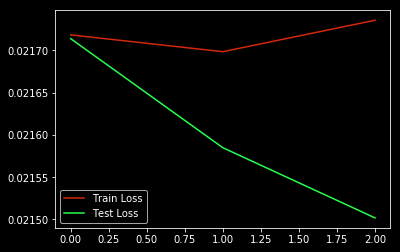


-----Condition score-----
{'precision': 0.5228215767634855, 'recall': 0.6268656716417911, 'F1': 0.5701357466063349}

-----Sequential event prediction score-----
0.40865918965343034
Saving experience at results/exp_2019-06-07_16:38:13_max_len-10_task-1.0_pred_layer-max_pooling.pt

Beginning experiment n° 1:
----------Parameters----------
device : cpu
pad_token : <pad>
batch_size : 32
max_len : 10
condition_task_weight : 1.0
prediction_layer : mean_pooling
embedding_dim : 100
hidden_dim : 128
dropout : 0.5

 Epoch 0, Train epoch Loss = 0.0216, Dev epoch Loss = 0.0215, time elapsed: 10.7383
Total train Loss: 129.82088339328766

 Epoch 1, Train epoch Loss = 0.0216, Dev epoch Loss = 0.0215, time elapsed: 10.7004
Total train Loss: 259.53826427459717

 Epoch 2, Train epoch Loss = 0.0216, Dev epoch Loss = 0.0215, time elapsed: 10.3950
Total train Loss: 389.1409016251564
------------------------------------------------

 Training ended, 
 Total train Loss = 389.1409, Total dev Loss = 129.1213,

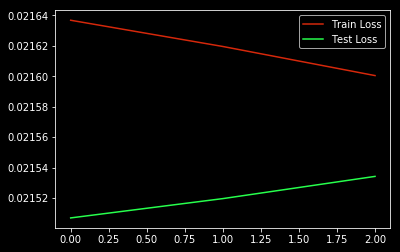


-----Condition score-----
{'precision': 0.5106048703849175, 'recall': 0.6487025948103793, 'F1': 0.5714285714285715}

-----Sequential event prediction score-----
0.4302889472620732
Saving experience at results/exp_2019-06-07_16:38:46_max_len-10_task-1.0_pred_layer-mean_pooling.pt

Beginning experiment n° 2:
----------Parameters----------
device : cpu
pad_token : <pad>
batch_size : 32
max_len : 10
condition_task_weight : 0.8
prediction_layer : mean_pooling
embedding_dim : 100
hidden_dim : 128
dropout : 0.5

 Epoch 0, Train epoch Loss = 0.0368, Dev epoch Loss = 0.0365, time elapsed: 11.8073
Total train Loss: 220.7264131307602

 Epoch 1, Train epoch Loss = 0.0366, Dev epoch Loss = 0.0364, time elapsed: 9.6366
Total train Loss: 440.3442634344101

 Epoch 2, Train epoch Loss = 0.0365, Dev epoch Loss = 0.0363, time elapsed: 12.6157
Total train Loss: 659.1575590372086
------------------------------------------------

 Training ended, 
 Total train Loss = 659.1576, Total dev Loss = 218.2199, to

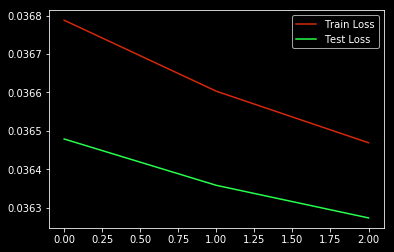


-----Condition score-----
{'precision': 0.5066225165562914, 'recall': 0.9125248508946322, 'F1': 0.6515259048970902}

-----Sequential event prediction score-----
0.5178336869758513
Saving experience at results/exp_2019-06-07_16:39:23_max_len-10_task-0.8_pred_layer-mean_pooling.pt


In [8]:
model_args = {
    'vocab': label2ix,
    'device': DEVICE,
    'pad_token': PAD,
    'batch_size': BATCH_SIZE
}

for nb_training in np.arange(3):
    
    for k, v in grid.items():
        model_args[k] = np.random.choice(v)

    print('\nBeginning experiment n° {}:'.format(nb_training))
    print('----------Parameters----------')
    [print('{} : {}'.format(k, v)) for (k, v) in model_args.items() if k != 'vocab']

    EXP_NAME = 'max_len-{}_task-{}_pred_layer-{}'.format(model_args['max_len'], model_args['condition_task_weight'], model_args['prediction_layer'])

    model = McRnn(**model_args).to(DEVICE)

    # optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    train_loss_history, validation_loss_history, epoch = model.train_model(
        sequences=sequences, 
        train_ids=partition['train'], 
        validation_ids=partition['validation'],
        optimizer=optimizer,
        nb_epochs=NB_EPOCHS
    )

    plot_history(train_loss_history, validation_loss_history)

    # evaluation and scoring
    my_condition_score = 0
    if model.condition_task_weight > 0:
        y_golds, y_preds, condition_golds, condition_preds = model.evaluate(sequences, partition['validation'])
        my_condition_score = condition_score(condition_preds, condition_golds)
    else:
        y_golds, y_preds = model.evaluate(sequences, partition['validation'])

    sep_score = accuracy_at_k(y_preds, y_golds, model.padding_idx)

    print('\n-----Condition score-----')
    print(my_condition_score)
    print('\n-----Sequential event prediction score-----')
    print(sep_score)
    
    if SAVE:
         save_model(
            model,
            model_args,
            partition,
            optimizer,
            epoch,
            train_loss_history,
            validation_loss_history,
            {'condition_score': my_condition_score, 'sep_score': sep_score},
            RESULTS_DIR,
            EXP_NAME
        )